In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import random
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib as mpl  

from helpers import *
pandarallel.initialize()
from pandarallel import pandarallel  

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [13]:
# CONFIG
gtFine_path = './data/P8_Cityscapes_gtFine_trainvaltest.zip'  
leftImg8bit_path = './data/P8_Cityscapes_leftImg8bit_trainvaltest.zip'  
data_path = 'data/gtFine'  

config_width = 256
config_height = 128
config_classes = 8
config_epoch = 3
config_learning_rate=1e-5
batch_size=3


In [14]:
df_train, df_test, df_val = get_dataframes(data_path, sample_dataset=0)

Using the full dataset


In [15]:
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(2975, 5)
(1525, 5)
(500, 5)


In [16]:
def read_overlay(image_path, mask_path, mask_opacity=0.5):  
    """  
    Display the mask on top of the image with an opacity of 0.5.  
      
    Parameters:  
    image_path (str): Path to the image file.  
    mask_path (str): Path to the mask file (in your case, path which will be processed by polygon_to_mask_img).  
    mask_opacity (float, optional): Opacity of the mask. Default is 0.5.  
      
    Returns:  
    numpy.ndarray: The overlaid image.  
    """  
      
    # Read the image and the mask  
    image = read_image(image_path)  
    mask = read_mask(mask_path)  
      
    # Convert the image to a format that can be handled by addWeighted (needs scaling up to 255 and converting to uint8)  
    image_for_overlay = (image * 255).astype(np.uint8)  
      
    # Blend the image and the mask  
    # mask_opacity for the mask weight, and 1-mask_opacity for the image to ensure they sum to 1 for proper blending  
    overlay_result = cv2.addWeighted(image_for_overlay, 1-mask_opacity, mask, mask_opacity, 0)  
      
    return overlay_result  

In [17]:
# Configurable dimensions: Update these based on your requirement or config 
def read_image(x):  
    x = cv2.imread(x, cv2.IMREAD_COLOR)  
    x = cv2.resize(x, (config_width, config_height))  
    x = x/255.0  
    x = x.astype(np.float32)  
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x  
  
def read_mask(path):  
    mask_img_array = polygon_to_mask_img(path)
    color_map = mpl.colormaps.get_cmap('viridis')  
      
    mask_img = cv2.resize(mask_img_array, (config_width, config_height))  
    return mask_img.astype(np.int32)

def read_mask_for_overlay(path):  
    mask_img_array = polygon_to_mask_img(path)  
    color_map = mpl.colormaps.get_cmap('viridis')  
              
    mask_img_array_normalized = mask_img_array / mask_img_array.max()  
    mask_img_colored = color_map(mask_img_array_normalized)[:, :, :3]  # Exclude the alpha channel  
    mask_img_colored = (mask_img_colored * 255).astype(np.uint8)  
      
    mask_img = cv2.resize(mask_img_colored, (config_width, config_height))  
    return mask_img  

def read_overlay(row, mask_opacity=0.5):  
    image = read_image(row["original_img_path"])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = read_mask_for_overlay(row["polygons_json_path"])  
      
    overlayed = cv2.addWeighted(src1=image, alpha=(1-mask_opacity), src2=mask.astype(np.float32)/255.0, beta=mask_opacity, gamma=0)  
    
    return overlayed

def tf_dataset(x,y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x,y)) # Dataset data object created from input and target data
    dataset = dataset.shuffle(buffer_size=100) ## selected from the first 100 samples
    dataset = dataset.map(preprocess) # Applying preprocessing to every batch in the Dataset object
    dataset = dataset.batch(batch) # Determine batch-size
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2) # Optimization to reduce waiting time on each object
    return dataset
        

def preprocess(x,y):
    def f(x,y):
        x = x.decode() ##byte stream conversion
        y = y.decode()
        image = read_image(x)
        mask = read_mask(y)
        return image, mask
    
    image, mask = tf.numpy_function(f,[x,y],[tf.float32, tf.int32])
    mask = tf.one_hot(mask, config_classes, dtype=tf.int32)
    
    image.set_shape([config_height, config_width, 3])    
    mask.set_shape([config_height, config_width, config_classes])
    
    return image, mask


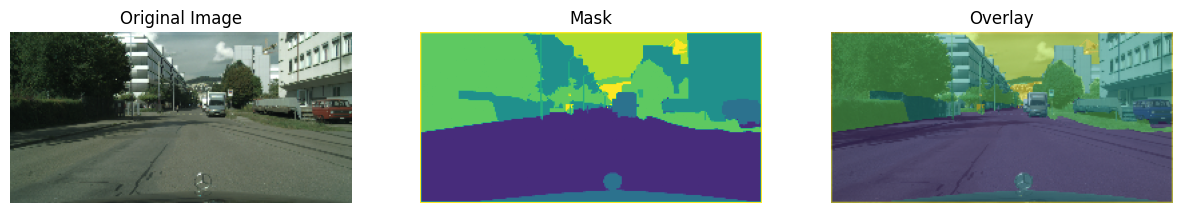

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  
  
img = read_image(df_train.loc[0]["original_img_path"])  
axs[0].imshow(img)  
axs[0].axis('off')  
axs[0].set_title("Original Image")  
  
mask = read_mask(df_train.loc[0]["polygons_json_path"])  
axs[1].imshow(mask)  
axs[1].axis('off')  
axs[1].set_title("Mask")  
  
overlay = read_overlay(df_train.loc[0])  
axs[2].imshow(overlay)  
axs[2].axis('off')  
axs[2].set_title("Overlay")  
  
plt.show()  

In [19]:
img_train = df_train["original_img_path"].tolist()
mask_train = df_train["polygons_json_path"].tolist()

img_val = df_val["original_img_path"].tolist()
mask_val = df_val["polygons_json_path"].tolist()

img_test = df_test["original_img_path"].tolist()
mask_test = df_test["polygons_json_path"].tolist()


In [20]:
train_dataset = tf_dataset(img_train, mask_train, batch = batch_size)
valid_dataset = tf_dataset(img_val, mask_val, batch = batch_size)

train_steps = len(img_train)//batch_size
valid_steps = len(img_val)//batch_size

def test_dataset(x, batch=32):
    dataset = tf.data.Dataset.from_tensor_slices(x)
    dataset = dataset.map(preprocess_test)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset
        

def preprocess_test(x):
    def f(x):
        x = x.decode()
        image = read_image(x)
        return image
    
    image = tf.convert_to_tensor(tf.numpy_function(f, [x] , [tf.float32]))
    image = tf.reshape(image, (config_height, config_width, 3))  
    return image



def multi_unet_model(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=config_learning_rate,  clipvalue=0.5)  
    # optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4,  clipvalue=0.5)  
    # optimizer = tf.keras.optimizers.legacy.Adam()  

    model.compile(optimizer=optimizer, loss=['categorical_crossentropy'], metrics=['accuracy'])
    
    model.summary()
    
    return model



In [21]:
model = multi_unet_model(n_classes=config_classes, IMG_HEIGHT=config_height, IMG_WIDTH=config_width, IMG_CHANNELS=3)
model

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 256, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 128, 256, 16)         448       ['input_2[0][0]']             
                                                                                                  
 dropout_9 (Dropout)         (None, 128, 256, 16)         0         ['conv2d_19[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 128, 256, 16)         2320      ['dropout_9[0][0]']           
                                                                                            

In [22]:
es = tf.keras.callbacks.EarlyStopping(min_delta=0.001, patience=5)
history = model.fit(train_dataset,
          steps_per_epoch=train_steps,
          validation_data=valid_dataset,
          validation_steps=valid_steps,
          epochs=config_epoch
         )

Epoch 1/3
991/991 [==============================] - 142s 142ms/step - loss: 1.8873 - accuracy: 0.1924 - val_loss: 1.7145 - val_accuracy: 0.4488
Epoch 2/3
991/991 [==============================] - 142s 143ms/step - loss: 1.1375 - accuracy: 0.5616 - val_loss: 1.3892 - val_accuracy: 0.4876
Epoch 3/3
991/991 [==============================] - 143s 145ms/step - loss: 0.9437 - accuracy: 0.6245 - val_loss: 1.1953 - val_accuracy: 0.5358


10/10 [==============================] - 0s 29ms/step


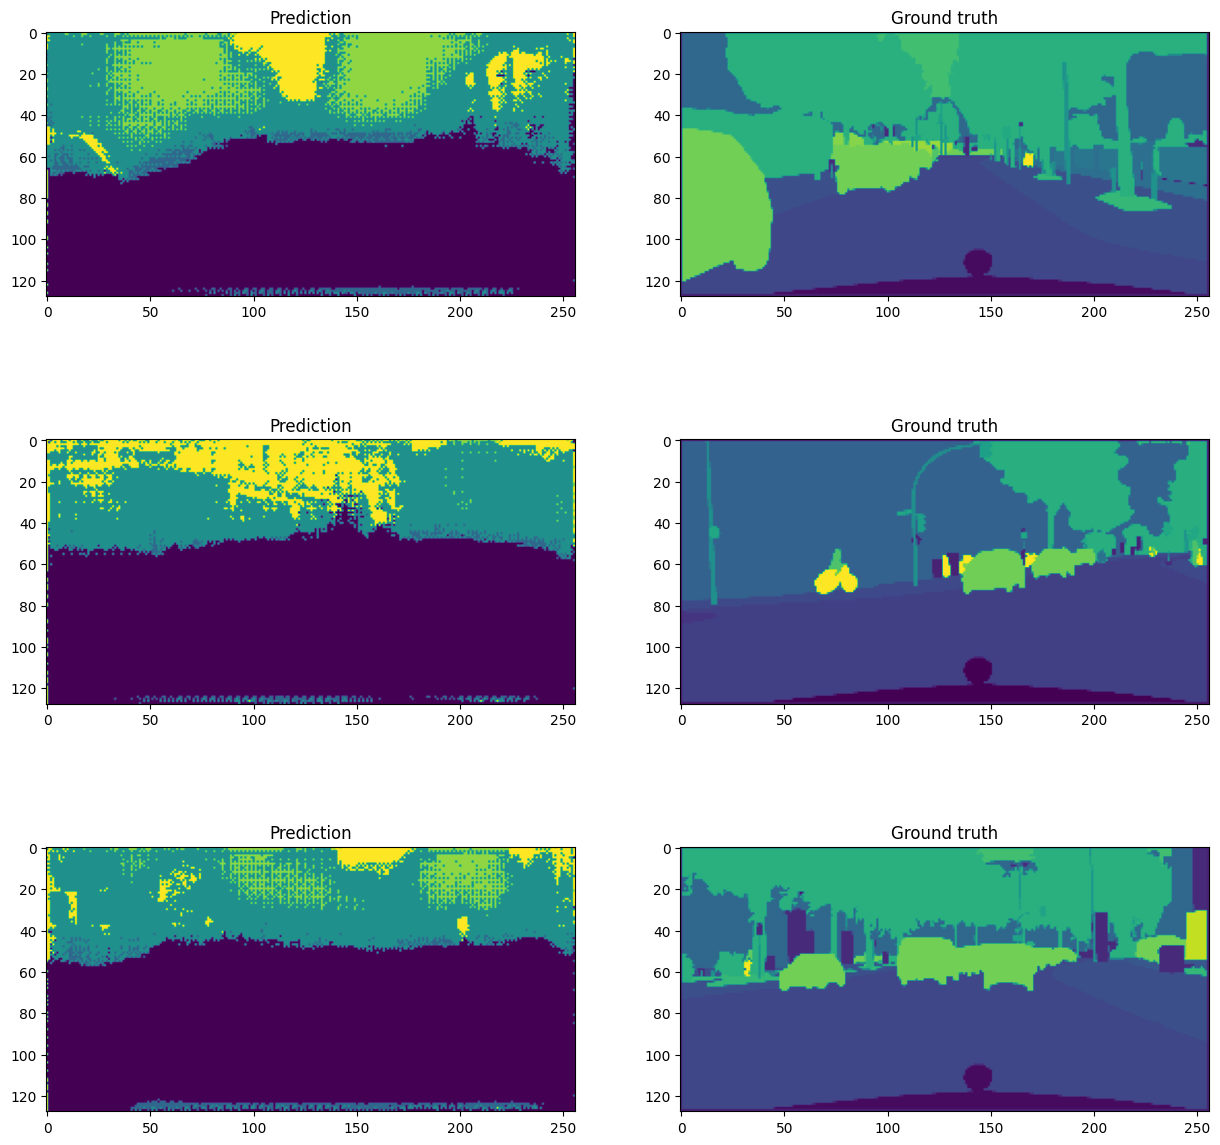

In [23]:
test_ds = tf_dataset(img_val, mask_val, batch = batch_size)
# test_ds = tf_dataset(img_test, mask_test, batch = batch_size)
model.evaluate(test_ds, steps=14)
pred = model.predict(test_dataset(img_val, batch = 1), steps=10)
# pred = model.predict(test_dataset(img_test, batch = 1), steps=10)

predictions = np.argmax(pred, axis=3)
label = np.array([cv2.resize(cv2.imread(df_val.loc[i]["label_ids_img_path"])[:, :, 0], (config_width, config_height)) for i in range(predictions.shape[0])])  
# label = np.array([cv2.resize(cv2.imread(df_test.loc[i]["label_ids_img_path"])[:, :, 0], (config_width, config_height)) for i in range(predictions.shape[0])])  
label = label.flatten()
predictions = predictions.flatten()

predictions = predictions.reshape(-1, config_height, config_width)  
label = label.reshape(-1, config_height, config_width)  

i = 3

fig, ax = plt.subplots(3, 2, figsize=(15, 15))
for j in range(3):
    ax[j, 0].imshow(predictions[i+j], cmap="viridis")
    ax[j, 1].imshow(label[i+j], cmap="viridis")
    ax[j, 0].set_title('Prediction')
    ax[j, 1].set_title('Ground truth')
    ax[j, 0].grid(False)
    ax[j, 1].grid(False)
    
plt.show()

1/1 [==============================] - 0s 31ms/step


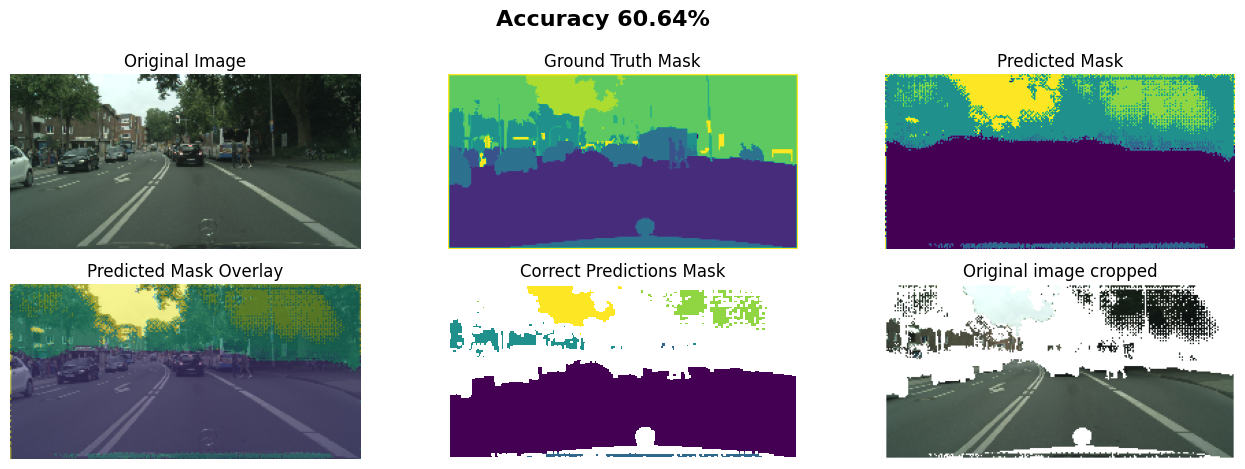

Accuracy: 60.64%


In [24]:
def read_overlay_pred(image, mask, mask_opacity=0.5):
    color_map = mpl.colormaps.get_cmap('viridis')  

    mask_img_array_normalized = mask / mask.max()  
    mask_img_colored = color_map(mask_img_array_normalized)[:, :, :3]  # Exclude the alpha channel  
    mask_img_colored = (mask_img_colored * 255).astype(np.uint8)  
      
    overlayed = cv2.addWeighted(src1=image, alpha=(1-mask_opacity), src2=mask_img_colored.astype(np.float32)/255.0, beta=mask_opacity, gamma=0)  
    
    return overlayed


def predict_and_display_image_with_accuracy(image_path, truth_mask_path, model):  
    # Load and preprocess the image  
    image = read_image(image_path)
    image_to_predict = np.expand_dims(image, axis=0)  # Add batch dimension  
      
    # Load and preprocess the truth mask  
    truth_mask = read_mask(truth_mask_path)  # Using the read_mask function defined earlier  
    truth_mask_resized = cv2.resize(truth_mask, (model.input_shape[2], model.input_shape[1]), interpolation=cv2.INTER_NEAREST)  # Resizing to match the model's input  
  
    # Predict the mask using the model  
    prediction = model.predict(image_to_predict)  
    predicted_mask = tf.argmax(prediction, axis=-1)[0]  # Remove batch dimension and convert prediction to class labels  
  
    # Calculate accuracy  
    accuracy = np.mean(predicted_mask == truth_mask_resized)  # Assumes truth_mask is already an int32 numpy array of labels  
    
    overlay_img = read_overlay_pred(image, predicted_mask.numpy())
    
    correct_predictions_mask = np.where(predicted_mask == truth_mask_resized, predicted_mask, np.nan)  # Use np.nan for non-correct pixels    
    # correct_predictions_mask_test = np.where(predicted_mask == truth_mask_resized, predicted_mask, np.nan)  # Use np.nan for non-correct pixels    
    
    correct_predictions_image = np.where(np.expand_dims(predicted_mask.numpy() == truth_mask_resized, axis=-1), image, 1) # This replaces incorrect predictions with black  

    # Display images
    titles_and_images = [  
        ('Original Image', image),  
        ('Ground Truth Mask', truth_mask_resized),  
        ('Predicted Mask', predicted_mask),  
        ('Predicted Mask Overlay', overlay_img),
        ('Correct Predictions Mask', correct_predictions_mask),
        ('Original image cropped', correct_predictions_image),
    ]  
    
    # Setting up the figure for 2 rows and 2 columns  
    plt.figure(figsize=(16, 5))  
    plt.suptitle(f'Accuracy {accuracy*100:.2f}%', fontsize=16, fontweight='bold', y=1.01)  
    
    for i, (title, img) in enumerate(titles_and_images, start=1):
        plt.subplot(2, 3, i)  
        plt.title(title)
        plt.imshow(img)
            
        plt.axis('off') 
         
    plt.show()  
  
    print(f"Accuracy: {accuracy*100:.2f}%")  


predict_and_display_image_with_accuracy(img_val[0],mask_val[0], model)

In [25]:
model.save("model_v5_full.h5")

/Users/m/dev/experiments/seg/unet/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
